_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez

Summer term 2023

Student names: Harald Kugler, Leander Zimmermann

# Coding Lab 1

- __Data__: Download the data file ```nds_cl_1.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.


Recommended folder structure:

```
.
├── data/
│   └── nds_cl_1.csv
├── notebooks
│   └── CodingLab1.ipynb
├── matplotlib_style.txt
└── requirements.txt
```

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA

# from __future__ import annotations  # for Python 3.8 and below

# black is a code formatter (see https://github.com/psf/black).
# It will automatically format the code you write in the cells imposing consistent Python style.
%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-04-23 21:21:42CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.12.0

sklearn: 1.2.2

scipy     : 1.10.1
numpy     : 1.24.2
pandas    : 2.0.0
matplotlib: 3.7.1

Watermark: 2.3.1



In [58]:
# matplotlib style file
# Template for style file: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
plt.style.use("../matplotlib_style.txt")

## Load data

In [59]:
fs = 30000.0  # sampling rate of the signal in Hz
dt = 1 / fs
cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
x = pd.read_csv("../data/nds_cl_1.csv", header=0, names=cols)

In [60]:
x.describe()

,Ch1,Ch2,Ch3,Ch4
count,1.920000e+07,1.920000e+07,1.920000e+07,1.920000e+07
mean,3.600331e+00,-8.850918e-01,2.864284e-01,2.210982e+00
std,5.824474e+02,6.014818e+02,6.464363e+02,6.126105e+02
min,-3.607000e+03,-3.739000e+03,-3.871000e+03,-3.750000e+03
25%,-3.460000e+02,-3.610000e+02,-3.950000e+02,-3.640000e+02
50%,1.200000e+01,8.000000e+00,-1.000000e+00,1.000000e+01
75%,3.650000e+02,3.720000e+02,4.010000e+02,3.810000e+02
max,2.873000e+03,3.004000e+03,3.099000e+03,3.017000e+03


## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filter_signal()```. A typical choice for this task would be a <mark>butterworth filter</mark>. Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

*Grading: 2 pts*


In [61]:
def filter_signal(
    x: pd.DataFrame, fs: float, low: float, high: float, order: int = 3
) -> pd.DataFrame:
    """Filter raw signal x.

    Parameters
    ----------

    x: pd.DataFrame, (n_samples, n_channels)
        Each column in x is one recording channel.

    fs: float
        Sampling frequency.

    low, high: float, float
        Passband in Hz for the butterworth filter.

    order: int
        The order of the Butterworth filter. Default is 3, but you should try
        changing this and see how it affects the results.


    Returns
    -------

    y: pd.DataFrame, (n_samples, n_channels)
        The filtered x. The filter delay is compensated in the output y.


    Notes
    ----

    1. Try exploring different filters and filter settings. More info:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

    2. The output signal should be phase-shift compensated. More info:
    https://dsp.stackexchange.com/a/19086

    """

    # insert your code here

    # --------------------------------------------------------------------
    # implement a suitable filter and apply it to the input data (1.5 pts)
    # --------------------------------------------------------------------
    b, a = signal.butter(N=order, Wn=[low, high], btype="bandpass", fs=fs)
    xf = signal.filtfilt(b, a, x, axis=0)
    return xf

In [62]:
xf = filter_signal(x, fs, 500, 4000)

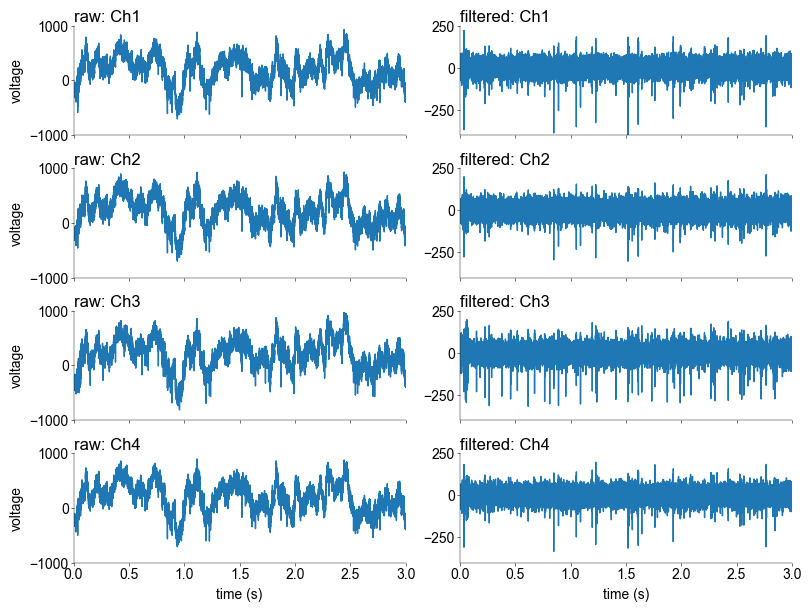

In [63]:
mosaic = [
    ["raw: Ch1", "filtered: Ch1"],
    ["raw: Ch2", "filtered: Ch2"],
    ["raw: Ch3", "filtered: Ch3"],
    ["raw: Ch4", "filtered: Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# -------------------------------------------------------
# Plot raw and filtered signals for all 4 channels (0.5 pt)
# -------------------------------------------------------
t = np.linspace(0, x.shape[0] * dt, x.shape[0])
for i, m in enumerate(mosaic):
    raw = m[0]
    filtered = m[1]
    ax[raw].set_xlim((0, 3))
    ax[raw].set_ylim((-1000, 1000))

    ax[filtered].set_xlim((0, 3))
    ax[filtered].set_ylim((-400, 250))

    ax[raw].set_ylabel("voltage")
    ax[filtered].set_title(m[1], loc="left")

    ax[raw].set_title(m[0], loc="left")

    ax[raw].plot(t, x.iloc[:, i])
    ax[filtered].plot(t, xf[:, i])

    if i != 3:
        ax[raw].set_xticklabels([])
        ax[filtered].set_xticklabels([])
    else:
        ax[raw].set_xlabel("time (s)")
        ax[filtered].set_xlabel("time (s)")

## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detect_spikes()``` . Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes. **Plot the threshold**. Are the detected time points well aligned with peaks in the signal?

*Grading: 3 pts*

In [64]:
def detect_spikes(
    x: np.ndarray, fs: float, N: int = 5, lockout: int = 10
) -> tuple[np.ndarray, np.ndarray, np.float64]:
    """Detect spikes, in this case, the relative local minima of the signal x.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal from Task 1.

    fs: float
        the sampling rate (in Hz).

    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.

    lockout: int
        a window of 'refactory period', within which there's only one spike.
        Default is 10 but you should also try changing it.


    Returns
    -------

    s: np.array, (n_spikes, )
        Spike location / index in the singal x.

    t: np.array, (n_spikes, )
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.

    thrd: float
        Threshold = -N * sigma.


    Tips
    ----

    Use scipy functions to detect local minima.
    Noted that there are four channels in signal x.

    """
    # insert your code here

    # ---------------------------------
    # compute the robust s.d. (0.5 pts)
    # ---------------------------------
    sigma_hats = np.zeros(4)
    for i in range(4):
        sigma_hats[i] = np.median(np.abs(x[:, i] - np.mean(x, axis=1)) / 0.6745)

    sigma = np.mean(sigma_hats)

    # -----------------------------
    # find all local minima (1.5 pts)
    # -----------------------------
    s = np.unique(signal.argrelmin(x, axis=0)[0])

    # ---------------------------------
    # calculate the threshold (0.5 pts)
    # ---------------------------------
    thrd = -N * sigma

    # I am pretty sure this should also work with signal.find_peaks
    # ---------------------------------
    s_thrd = s[np.min(xf[s], axis=1) < thrd]

    s = [s_thrd[0]]
    for spike in s_thrd[1:]:
        if spike - s[-1] >= lockout:
            s.append(spike)

    s = np.array(s)

    t = (s - s[0]) / fs * 1000

    return s, t, thrd

In [65]:
s, t_s, thrd = detect_spikes(x=xf, fs=fs)

In [66]:
print(s.shape, t.shape)
print(s[0], t[0])

(277340,) (19199999,)
111 0.0


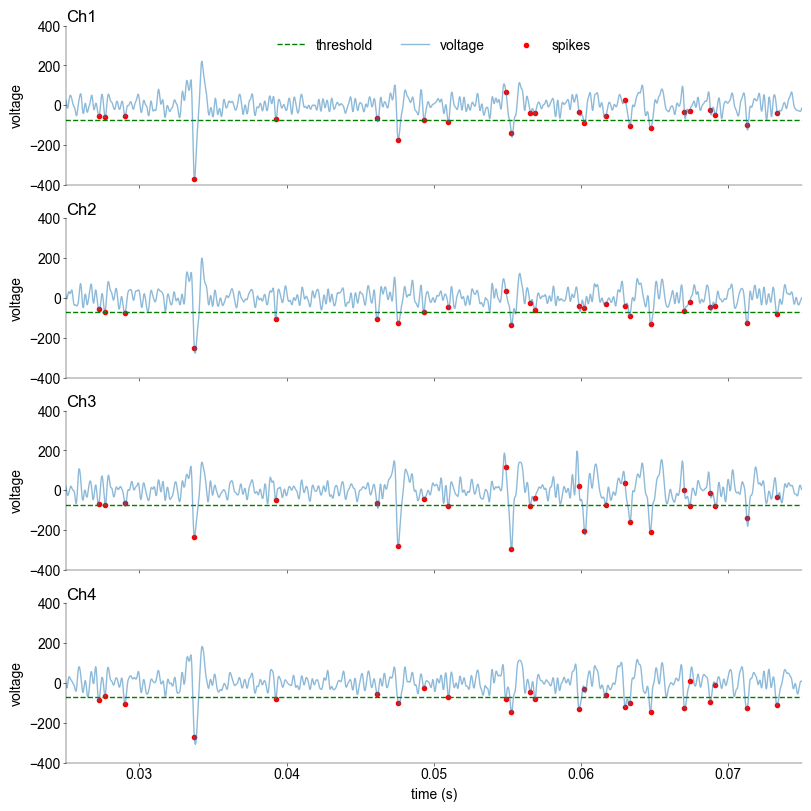

In [67]:
mosaic = [
    ["Ch1"],
    ["Ch2"],
    ["Ch3"],
    ["Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# --------------------------------------------
# plot threshold and detected spikes (0.5 pts)
# --------------------------------------------

for i, col in enumerate(cols):
    ax[col].set_ylim((-400, 400))
    ax[col].set_xlim((0.025, 0.075))
    ax[col].set_ylabel("voltage")

    ax[col].set_title(col, loc="left")

    ax[col].hlines(thrd, 0, 3, color="green", linestyle="--", label="threshold")

    # plotting filtered voltage line - as before
    ax[col].plot(
        t[s[0] :] - t[s[0]],  # times starting at first spike (0ms)
        xf[s[0] :, i],  # voltage of ith channel starting at first spike
        alpha=0.5,
        label="voltage",
    )
    # marking detected spikes
    ax[col].scatter(
        t_s / 1000,  # spike times in seconds
        xf[s, i],  # spike voltages
        color="red",
        label="spikes",
    )

    if col != "Ch4":
        ax[col].set_xticklabels([])
    else:
        ax[col].set_xlabel("time (s)")

ax["Ch1"].legend(loc="upper center", ncols=3)

plt.show()

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extract_waveforms()```. Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected. Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 2 pts*

In [81]:
def extract_waveforms(x: np.ndarray, s: np.ndarray) -> np.ndarray:
    """Extract spike waveforms at times s (given in samples)
    from the filtered signal `xf` using a fixed window around the
    times of the spikes.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal.

    s: np.array, (n_spikes, n_channels)
        Spike time in samples.


    Return
    ------

    w: np.array, (n_spikes, length_window, n_channels)
        Waveforms. (You don't have to get the exact same
        shape as we noted here. It's just the shape of w
        that can be easily retrieved via broadcasting.)


    Notes
    -----

    More on Numpy Broadcasting
    https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html

    """

    # ------------------------------
    # extract spike waveforms (1 pt)
    # ------------------------------

    n_spikes = len(s)
    n_channels = x.shape[1]
    length_window = 30
    half_window = int(length_window / 2)

    w = np.stack([x[-half_window + spike : spike + half_window] for spike in s])

    assert w.shape == (n_spikes, length_window, n_channels)

    return w

In [82]:
waveforms = extract_waveforms(x=xf, s=s)

Plot first 100 spike waveforms

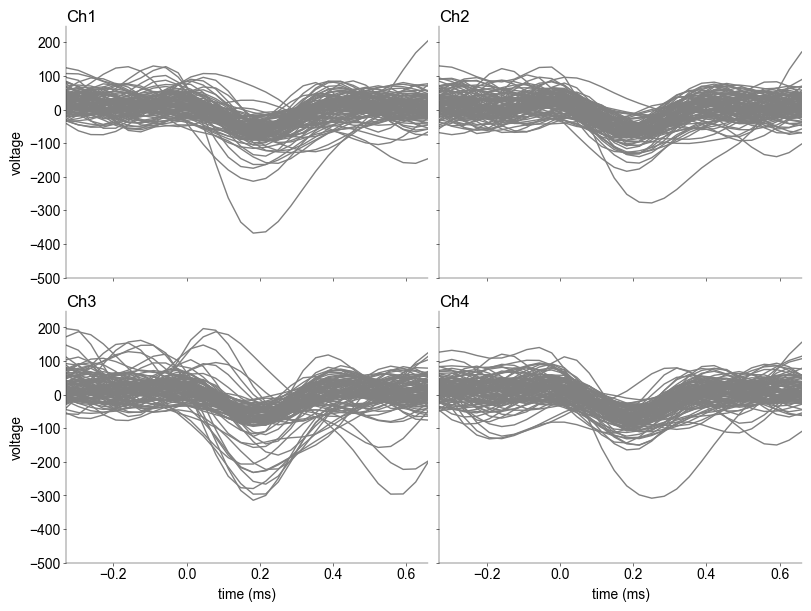

In [83]:
mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# -------------------------------
# plot first 100 spikes (0.5 pts)
# -------------------------------
x_limits = (-0.33, 0.66)
y_limits = (-500, 250)

waves = waveforms[:100, ...]
t_s = np.linspace(x_limits[0], x_limits[1], num=waves.shape[1])

# cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
for i, col in enumerate(cols):
    ax[col].set_ylim(y_limits)
    ax[col].set_xlim(x_limits)
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage")
    else:
        ax[col].set_yticklabels([])

    ax[col].plot(t_s, waves[..., i].T, color="grey")

Plot largest 100 spike waveforms

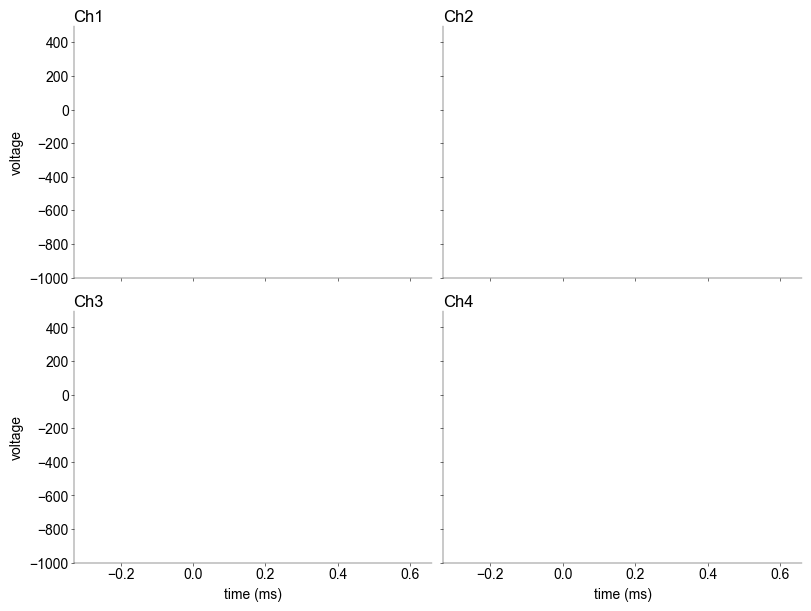

In [ ]:
mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# -------------------------------------
# plot the largest 100 spikes (0.5 pts)
# -------------------------------------

# cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
for i, col in enumerate(cols):
    ax[col].set_ylim((-1000, 500))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage")
    else:
        ax[col].set_yticklabels([])

## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extract_features()``` (2 pts). You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs.
Plot scatter plots for all pairwise combinations of 1st PCs. Do you see clusters visually? 

*Grading: 2+1 pts*


### PCA:
- how to preprocess data?


(https://stats.stackexchange.com/questions/385775/normalizing-vs-scaling-before-pca)

In [ ]:
def extract_features(w: np.ndarray):
    """Extract features for spike sorting from the waveforms w.

    Do PCA on the waveforms of each channel separately,
    then concatenate the first three principal components
    of each channels into one numpy array (`b`).


    Parameter
    ---------

    w: np.ndarray, (n_spikes, length_window, n_channels)
        Waveforms from Task 3.


    Return
    ------

    b: np.ndarray, (n_spikes, n_feature)


    Notes
    -----

    You can use PCA from sklearn.

    More on PCA
    https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

    """

    # insert your code here

    # ---------------------------------------------
    # obtain first 3 principle components (1.5 pts)
    # ---------------------------------------------

    # -----------------------------------------------------
    # Print the fraction of variance explained (1 extra pt)
    # -----------------------------------------------------

    pass

Text(0.5, 0.98, 'Pairwise 1st PCs')

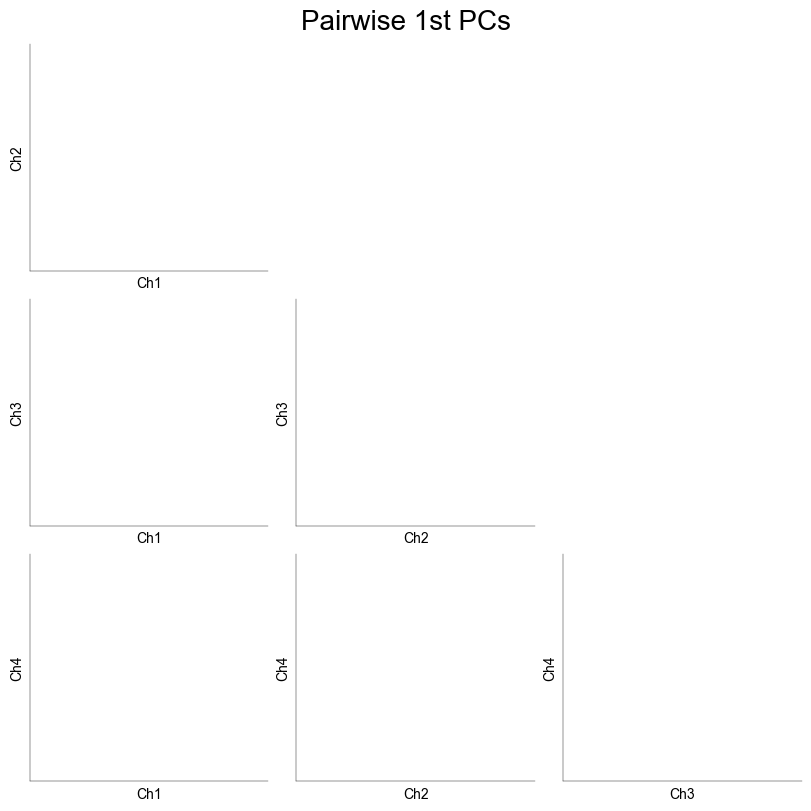

In [ ]:
mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# indices of the 1st PC in `b`
i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}

for m in np.ravel(mosaic):
    if m == ".":
        continue
    y, x = m.split(" vs ")

    ax[m].set_xlabel(x)
    ax[m].set_ylabel(y)
    ax[m].set_xlim((-1500, 1500))
    ax[m].set_ylim((-1500, 1500))
    ax[m].set_xticks([])
    ax[m].set_yticks([])

fig.suptitle("Pairwise 1st PCs", fontsize=20)

In [ ]:
# # save data for the next Coding Lab

# np.save("../data/nds_cl_1_features", b)
# np.save("../data/nds_cl_1_spiketimes_s", s)
# np.save("../data/nds_cl_1_spiketimes_t", t)
# np.save("../data/nds_cl_1_waveforms", w)